In this notebook, we propose a simple but original implementation from scratch of an text classifier on a Twitter sentiment dataset. The goal is to detect hate tweets. The dataset is composed of +16k tweets belonging to 2 different classes.


Our model uses the glove6b embedding of words followed by a Bidirectional LSTM and Dense layers.
The performance of our algorithm is computed in the last cell of the notebook.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.utils as ku 
import tensorflow_hub as hub

from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.utils import class_weight

import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


print(tf.__version__)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2.6.2


Let us load the dataset:

In [2]:
data=pd.read_csv('../input/twitter-sentiment-analysis-hatred-speech/train.csv',
                 index_col= "id")

and explore the first rows:

In [3]:
data.head()

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation


Let us proceed to a simple pre processing of the tweets by stemming, removing stop words and abbreviations.

In [4]:
# This preprocessing is inspired from the notebook https://www.kaggle.com/rashmimanwani/twitter-sentiment-analysis-bidirectional-lstm
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"#", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = text.strip(' ')
    return text

data['tweet'] = data['tweet'].map(lambda t: clean_text(t))


    
stemmer=PorterStemmer()
def stem_remove_sw(df,text_col):
    corpus = []
    for i in range(len(df)):
        review = str(df[text_col].iloc[i])
        review = review.split()
        review = [stemmer.stem(word) for word in review if word not in stop_words]
        review = " ".join(review)
        corpus.append(review)
    return corpus

Tweets = stem_remove_sw(data, 'tweet')
y=data.label

We now split the dataset into train and validation datasets:

In [5]:
# We divide the dataset into train and validation datasets
split = 0.1
i_split = int(len(Tweets)*split)
Tweets_val = Tweets[:i_split]
y_val = y[:i_split]
Tweets_train = Tweets[i_split:]
y_train = y[i_split:]


Let us format the input data by tokenizing the words and padding the sequences to a fixed length

In [6]:
#We use a Tokenizer to transform each tweet in a sequence of token integers.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Tweets_train)
X = tokenizer.texts_to_sequences(Tweets)
total_words = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index


# We pad the sequences to match the maximal sequence length of the training set
max_sequence_len = max([len(x) for x in X[i_split:]])
X = np.array(pad_sequences(X, maxlen=max_sequence_len, padding='pre'))

#We divide X between training and validation sets
X_val = X[:i_split]
X_train = X[i_split:]

print(total_words)
print(X_train.shape)

30732
(28766, 38)


Now, we import the Glove word embedding as a matrix

In [7]:
embeddings_index = {};
with open('../input/glove6b100dtxt/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((total_words, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

Let us now build our model, composed of the Glove embedding, followed by a BiLSTM and Dense layers. We include Dropout and L2 regularizers. The final layer is a sigmoid because this is a binary classifcation task.

In [8]:
model = Sequential([
    Embedding(total_words, 100, input_length=max_sequence_len, weights=[embeddings_matrix], trainable=False),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences = True,
                       activation="relu",
                       kernel_regularizer=regularizers.l2(0.01))),
    Dropout(0.2),
    Bidirectional(LSTM(16, return_sequences = False,
                       activation="relu",
                       kernel_regularizer=regularizers.l2(0.01))),
    Dropout(0.2),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
    ])

model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

model.summary()

2022-03-28 14:10:31.689567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 14:10:31.790068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 14:10:31.790794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 14:10:31.791946: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 38, 100)           3073200   
_________________________________________________________________
dropout (Dropout)            (None, 38, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 38, 128)           84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

The dataset is imbalanced because it contains much more examples targeted as 0. A good practice is therefore to weight the loss accordingly, so that we will give more importance to the examples targeted as 1 to compensate their sparsity.

In [9]:
# Calculate the weights for each class so that we can balance the data
weights = class_weight.compute_class_weight('balanced',
                                            classes = np.unique(y_train),
                                            y = y_train)
weights= {key: value for key,value in enumerate(weights)}

We use an EarlyStopping callback during training:

In [10]:
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=200)

Let us train our model:

In [11]:
history = model.fit(X_train, y_train, 
                    epochs=500,
                    batch_size=256, 
                    verbose=0, 
                    validation_data = (X_val, y_val),
                   callbacks=[EarlyStop],
                   class_weight=weights)



2022-03-28 14:10:34.996696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


We save our model and print the training history.

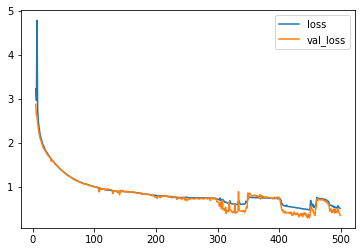

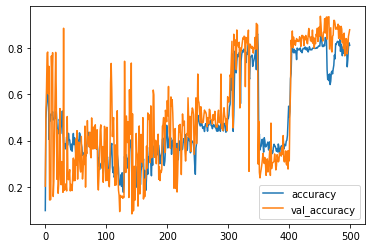

In [12]:
def print_save(model, history, name, save=True, plot=True):
    
    hist_df = pd.DataFrame(history.history)
    
    if save:
        model.save(name)
        hist_csv_file = name+'_history.csv'
        with open(hist_csv_file, mode='w') as f:
            hist_df.to_csv(f)
    if plot:
        hist_df[["loss",'val_loss']][5:].plot()
        hist_df[["accuracy",'val_accuracy']].plot()
        
        
        
        
print_save(model, history, 'model',save=False)

Let us finally compute the performances of our model and compare it to a baseline model that always predict the target "0".

In [13]:
y_hat=tf.cast(model.predict(X_val)[:,0]>0.5, tf.float32).numpy()
y_baseline = np.ones(len(y_val))* float(y_train.mean()>0.5)


scores= pd.DataFrame()
for name, y in {"prediction" : y_hat, "baseline" : y_baseline}.items():
    accuracy = tf.keras.metrics.Accuracy()(y_val, y).numpy()
    precision = tf.keras.metrics.Precision()(y_val, y).numpy()
    cross_table = pd.crosstab(y_val,y,margins = False, normalize = True)
    if name == "prediction":
        TN_ratio, FN_ratio, FP_ratio, TP_ratio = cross_table.iloc[0,0], cross_table.iloc[0,1], cross_table.iloc[1,0], cross_table.iloc[1,1]
    else:
        TN_ratio, FN_ratio, FP_ratio, TP_ratio = cross_table.iloc[0,0],0., cross_table.iloc[1,0], 0.
    
    score = pd.Series({"accuracy": accuracy, "precision": precision,
              "TN_ratio":TN_ratio, "FN_ratio":FN_ratio, 
               "FP_ratio":FP_ratio, "TP_ratio":TP_ratio}, name = name)
    scores = scores.append(score)
    
scores



,accuracy,precision,TN_ratio,FN_ratio,FP_ratio,TP_ratio
prediction,0.879850,0.334016,0.828849,0.10169,0.018461,0.051001
baseline,0.930538,0.000000,0.930538,0.00000,0.069462,0.000000
